In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# set seabron style and matplotlib parameters for very nice plotting
sns.set_style('whitegrid')
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = [10,6]

# Probability Distributions 📈
This notebook covers the most important features of probability distributions and showcases some probability distributions.

## Properties
#### Discrete vs. Continuous
One of the most important distinction is between <b>discrete</b> or <b>continuous</b> probability distributions. Discrete probability functions assign a probility to each possible outcome, e.g. the probability of heads when tossing a coin. With continuous probability distributions the probability for specific outcomes is zero. Instead we just can calculate probabilities for intervals, e.g. probability of having an IQ above two standard deviations. 

#### Probability Mass Function (pmf) or Probability Density Functions (pdf)
Discrete probability distributions are specified by a pmf and continuous by a pdf. The pmf directly tells us the probability for each outcome and the probabilities of all possible outcomes sum up to 1. The values from a pdf do not correspond to probabilities of the respective outcome. Instead the <b>area under the curve (AUC)</b> sums up to 1. Hence, we have to define an interval and calculate the AUC of this interval to arrive at a probability.

#### Cumulative distribution function (cdf)
The cdf presents the probability that an outcome $x$ is less than or equal to $x$:
$$F_X(x)=P(X\leq x)$$

Hence, the cdf gives us the AUC from $-\infty$ to $x$. So cdfs are non-decreasing.

#### Support
Discrete and continuous probability distributions can be defined in different value ranges (range where probability of each outcome is higher than zero). Most discrete probability distributions are defined for positive integers. Continuous probability distributions can be defined between $-\infty$ and $+\infty$ (e.g. Normal), between $0$ and $+\infty$ (e.g. Gamma), or between $0$ and $1$ (e.g. Beta).

## Using Probability Distributions with Python

The stats module from <b>SciPy</b> delivers a bunch of different probability distributions including functions for sampling, pdf, and cdf. You can find all information at the SciPy documentation: <url>https://docs.scipy.org/doc/scipy/reference/stats.html</url>

When you are using <b>PyMC</b> you have to use the distributions that come with PyMC. You can find the list here: <url>https://www.pymc.io/projects/docs/en/stable/api/distributions.html</url>

We will have a look how it works with both packages, but this notebook mainly uses SciPy instead of PyMC because SciPy brings a much higher functionality.

### PyMC

You can define distributions with PyMC outside models with <code>dist = pm.Distribution.dist(parameters)</code>. Then you can sample with <code>pm.draw(dist, draws=n)</code> and calculate log probabilities with <code>dist.logp(x).eval()</code>.

Here is an example for the Normal distribution:

In [3]:
normDist = pm.Normal.dist(mu=0, sigma=1) # define Normal distrubtion with mu=0 and sd=1

In [4]:
pm.draw(normDist, draws=10) # draw ten samples

array([ 0.70104516, -0.63607774,  1.06667525, -1.48381615,  0.9697114 ,
        1.3037357 , -1.00945742, -1.70273843, -0.00555996, -0.44582651])

A possible way to plot the distribution is to draw many many samples and create a histogram, or a sampling-based <b>probability density function (pdf)</b> based on a <b>kernel density estimate (kde)</b> with SciPy stats:

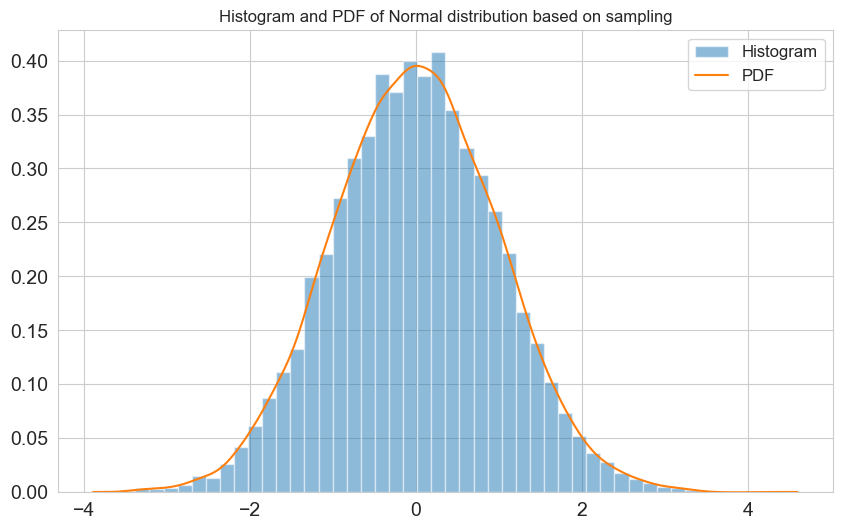

In [5]:
samplesNorm = pm.draw(normDist, draws=10000)

plt.figure()
plt.title('Histogram and PDF of Normal distribution based on sampling')

#histogram
plt.hist(samplesNorm, bins=50, alpha=.5, density=True, label='Histogram')

# pdf based on kde with SciPy stats
kdeSamples = stats.gaussian_kde(samplesNorm) # create normal kde
positions = np.linspace(start=samplesNorm.min(), stop=samplesNorm.max(), num=500) # get x values
pdfEstimate = kdeSamples(positions) # get v values of kde at x values
plt.plot(positions, pdfEstimate, label='PDF')

plt.legend() # add legend
plt.show()

To make life even simpler, we can use <b>ArviZ</b> and its <code>az.plot_posterior()</code> function, that plots a KDE-based PDF:

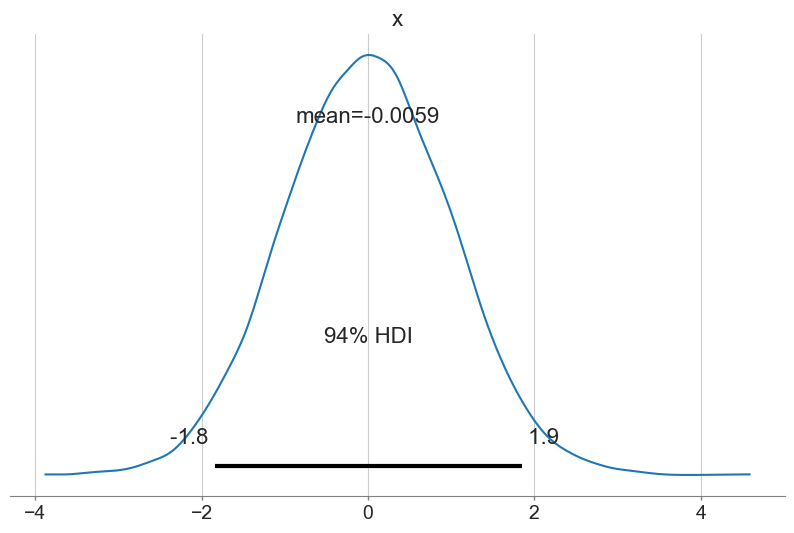

In [6]:
az.plot_posterior(samplesNorm);

### SciPy
The SciPy stats module brings more functionality compared to PyMC. Here we can directly use pdfs, cdfs, and some statistics. Also sampling is possible. You can define a distribution with <code>dist = stats.distribution(parameters)</code>, and sample with <code>dist.rvs(size=n)</code>. Again, we can have a look at the Normal distribution:

In [17]:
normDist = stats.norm(loc=0, scale=1)

# sample from distribution
normDist.rvs(size=10)

array([ 2.68712264,  0.0627912 ,  0.64024398, -0.3086061 ,  0.61709246,
        1.08744737,  1.0897795 ,  0.37487022,  1.72629849,  0.5404546 ])

Now we can plot the <b>pdf</b> and <b>cumulative density function (cdf)</b> without sampling. First, we have to define the x-range with <code>np.linspace(start, stop, n)</code> based on the percent point function (ppf, inverse of cdf) <code>dist.ppf(percent point)</code>. Then we can use <code>dist.pdf(x)</code> and <code>dist.cdf(x)</code> to get the corresponding values:

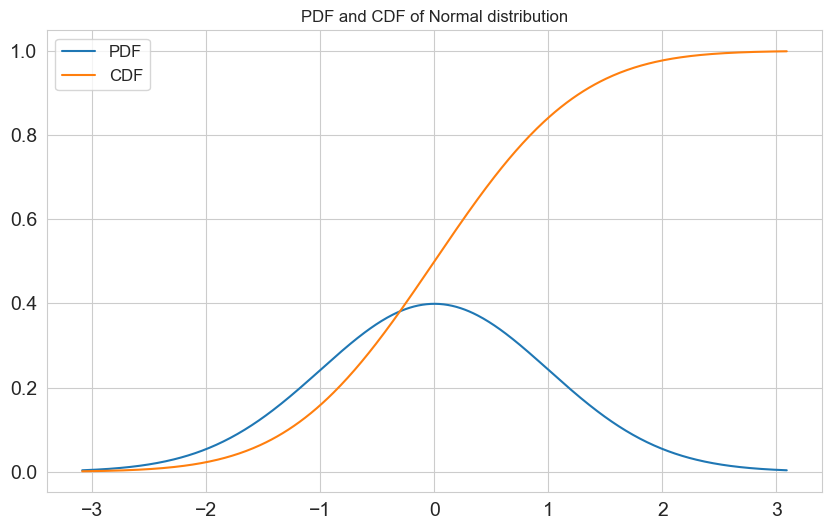

In [18]:
positions = np.linspace(start=normDist.ppf(.001), stop=normDist.ppf(.999), num=500) # ppf -> percent point function (inverse of cdf)

plt.figure()
plt.plot(positions, normDist.pdf(positions), label='PDF')
plt.plot(positions, normDist.cdf(positions), label='CDF')
plt.title('PDF and CDF of Normal distribution')
plt.legend()
plt.show()

## Calculating interval probabilities
After inferring a posterior distribution we usually want to answer questions like: what's the probability that $x>1$, the probability that $x$ lies between 0 and 1, or what's the range where the true parameter value of $x$ lies with a $95\%$ probability? To answer these questions we can use the <b>cdf</b>.

So we can answer the first question:

In [19]:
print(f'The probability that x is higher than 1 is: {(1-normDist.cdf(1)).round(2)}')

The probability that x is higher than 1 is: 0.16


We can visualize this as <b>area under the curve (AUC)</b> of the pdf:

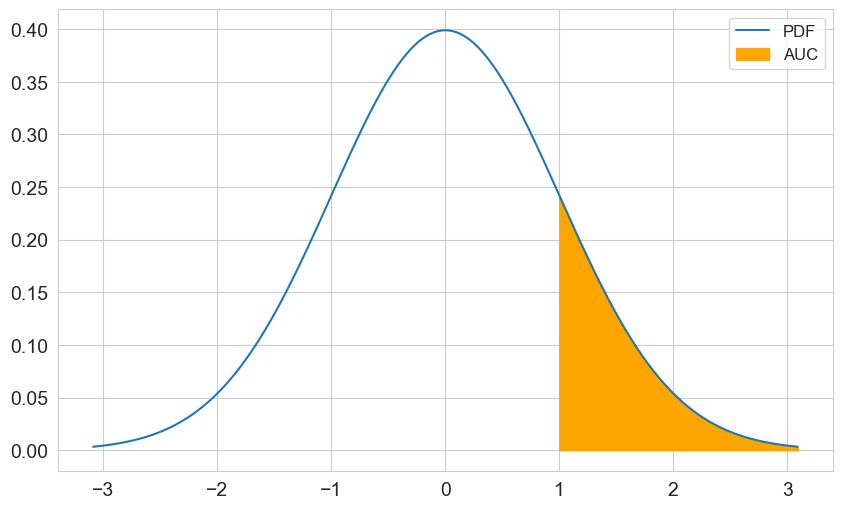

In [20]:
plt.figure()
# plot pdf
plt.plot(positions, normDist.pdf(positions), label='PDF')

# plot auc
positionsAUC = np.linspace(start=1, stop=normDist.ppf(.999), num=500)
plt.fill_between(positionsAUC, np.zeros(500), normDist.pdf(positionsAUC), color='orange', label='AUC')

plt.legend()
plt.show()

For the second question we have to calculate the density between two points:
$$P(a<X\leq b)=F_X(b)-F_X(a)$$
So we can use the cdf again:

In [21]:
print(f'Probability that x lies between 0 and 1: {(normDist.cdf(1)-normDist.cdf(0)).round(2)}')

Probability that x lies between 0 and 1: 0.34


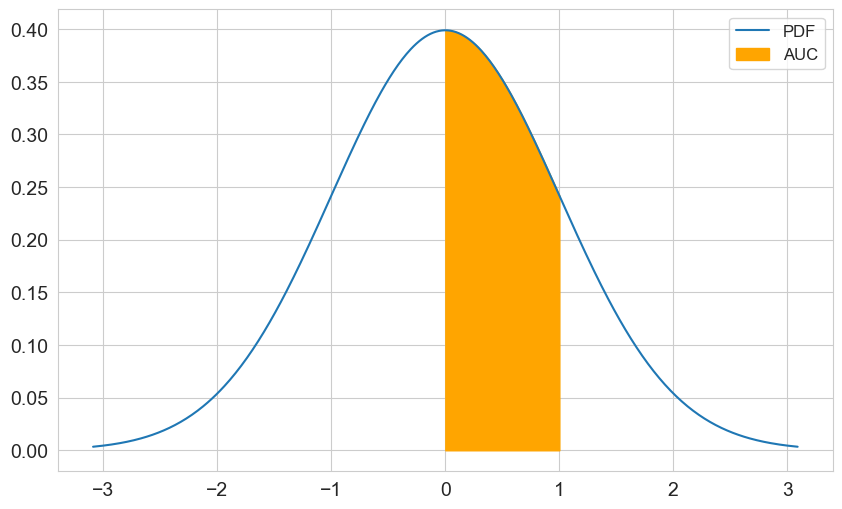

In [22]:
plt.figure()
# plot pdf
plt.plot(positions, normDist.pdf(positions), label='PDF')

# plot auc
positionsAUC = np.linspace(start=0, stop=1, num=500)
plt.fill_between(positionsAUC, np.zeros(500), normDist.pdf(positionsAUC), color='orange', label='AUC')

plt.legend()
plt.show()

The third question corresponds to finding the $95\%$ credible interval, hence the narrowest interval where $95\%$ of the density can be found. We can find this interval of highest density with <code>dist.ppf()</code>. So it looks like this:

<font color='red'>CAVEAT: This approach only works for symmetrical distributions!</font>

In [23]:
hdi = .95
a = normDist.ppf((1-hdi)/2)
b = normDist.ppf(hdi+(1-hdi)/2)
print(f'The true parameter value lies with a 95% probability between {a.round(2)} and {b.round(2)}')

The true parameter value lies with a 95% probability between -1.96 and 1.96


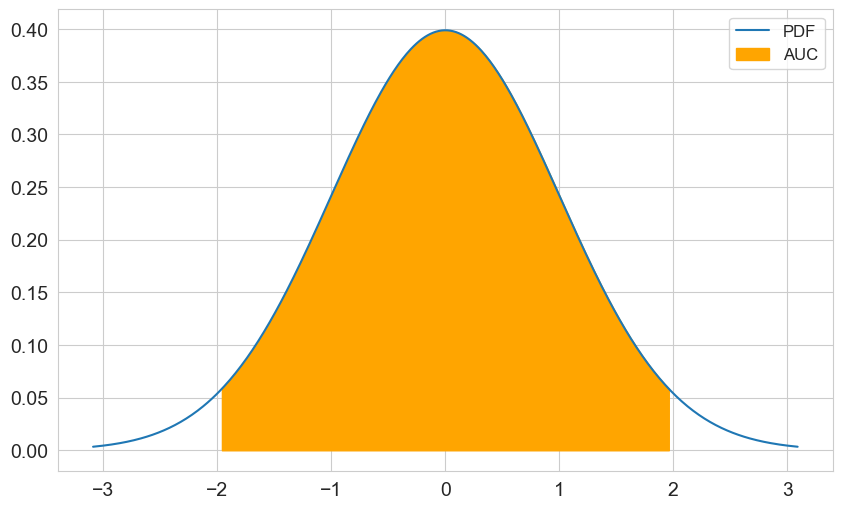

In [24]:
plt.figure()
# plot pdf
plt.plot(positions, normDist.pdf(positions), label='PDF')

# plot auc
positionsAUC = np.linspace(start=normDist.ppf((1-hdi)/2), stop=normDist.ppf(hdi+(1-hdi)/2), num=500)
plt.fill_between(positionsAUC, np.zeros(500), normDist.pdf(positionsAUC), color='orange', label='AUC')

plt.legend()
plt.show()

## <font color=#D28140><u>Exercise:</u></font> 👩🏻‍💻
- Create a <i>HalfNormal</i> distribution with SciPy and plot the pdf.
- Find two examples where you could use the HalfNormal distribution.
- Calculate and plot the $50\%$ HDI. Because HalfNormal is not symmetrical you can use <code>az.hdi(samples, hdi_prob=hdi)</code>
- Calculate and plot the probability for $x\leq1$ and $\geq2$.


## <font color=#D28140><u>Exercise:</u></font> 👩🏻‍💻
- Play around with the parameters of the following distributions.
- Find an example (from psychology if possible) for each distribution.
- Add another discrete or continuous distribution.

## Discrete Probability Distributions 📊

In [26]:
# define function that plots pmf of discrete distributions
def plot_discrete_dist(distObj, name):
    positions = np.arange(start=distObj.ppf(.001), stop=distObj.ppf(.999)+1)

    plt.figure()
    plt.plot(positions, distObj.pmf(positions), 'o', ms=10)
    plt.vlines(positions, 0, distObj.pmf(positions), colors='b', lw=5, alpha=0.5)
    plt.title(f'PMF {name} distribution')
    plt.show()

### <font color=Navy Blue>Bernoulli</font>
$$f(k)=\begin{cases}1-p & \text{if } k=0\\
p & \text{if } k=1 \end{cases}$$

for $k$ in $\{0,1\}, 0\leq p\leq 1$

- support: $\{0,1\}$
- parameter: probability of success $p$
- example:

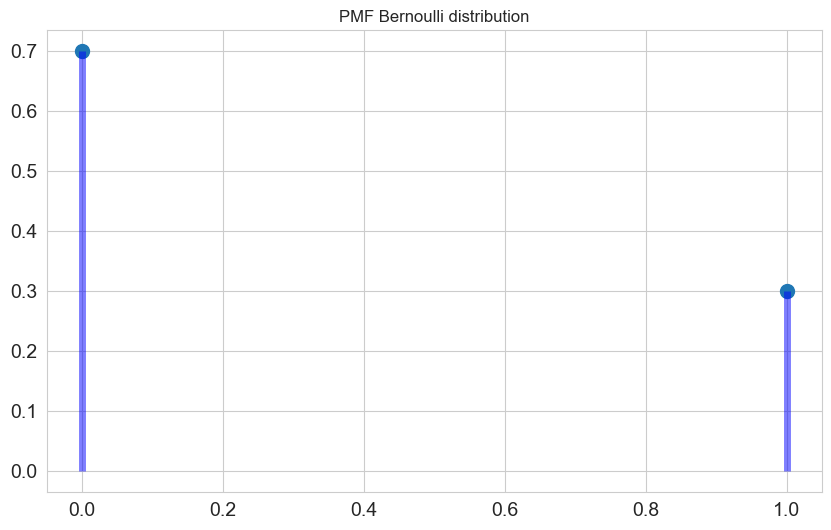

In [27]:
p = .3 
bernoulliDist = stats.bernoulli(p=p)

plot_discrete_dist(bernoulliDist, 'Bernoulli')

### <font color=Navy Blue>Binomial</font>
$$f(k)=\binom{n}{k}p^k(1-p)^{n-k}$$

for $k\in\{0,1,\dots,n\},0\leq p\leq1$

- support: $\{0, n\}$
- parameters: number of draws $n$, probability of success $p$
- example:

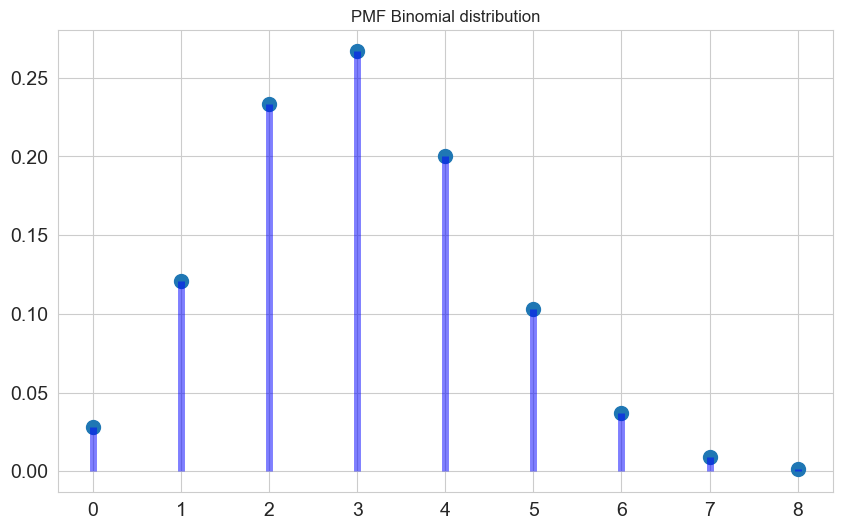

In [28]:
p = .3
n = 10
binomialDist = stats.binom(n=n, p=p)

plot_discrete_dist(binomialDist, 'Binomial')

### <font color=Navy Blue>Beta-binomial distribution</font>
Like Binomial, but $p$ is not fixed but sampled from a Beta distribution (see continuous distributions).
$$f(k)=\binom{n}{k}\frac{B(k+a,n-k+b)}{B(a,b)}$$

for $k\in\{0,1,\dots,n\},n\geq0,a>0,b>0$

- support: $\{0,n\}$
- parameters: number of draws $n$, $a$ and $b$ that define beta distribution
- example:

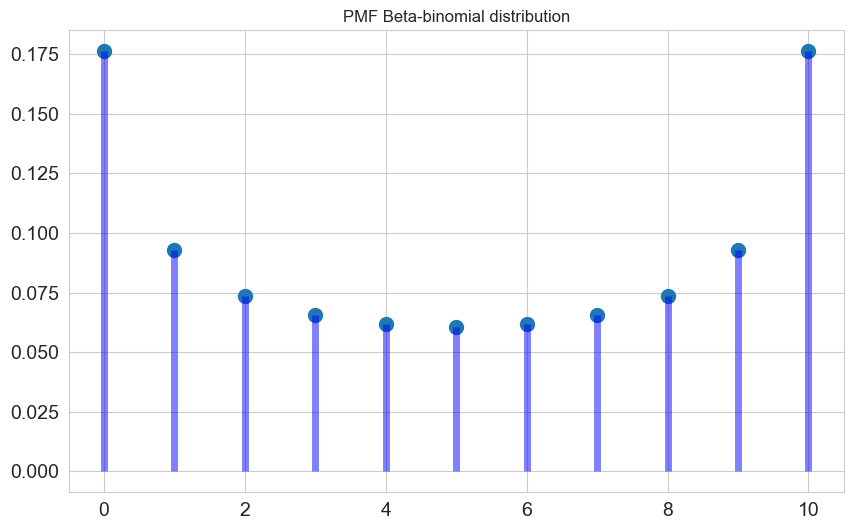

In [29]:
n = 10
a = .5
b = .5
betabinomDist = stats.betabinom(n=n, a=a, b=b)

plot_discrete_dist(betabinomDist, 'Beta-binomial')

### <font color=Navy Blue>Poisson</font>
$$f(k)=\exp(-\mu)\frac{\mu^k}{k!}$$

for $k\geq0$

- support: $\{0,\infty\}$
- parameter: constant mean rate $\mu$
- example:

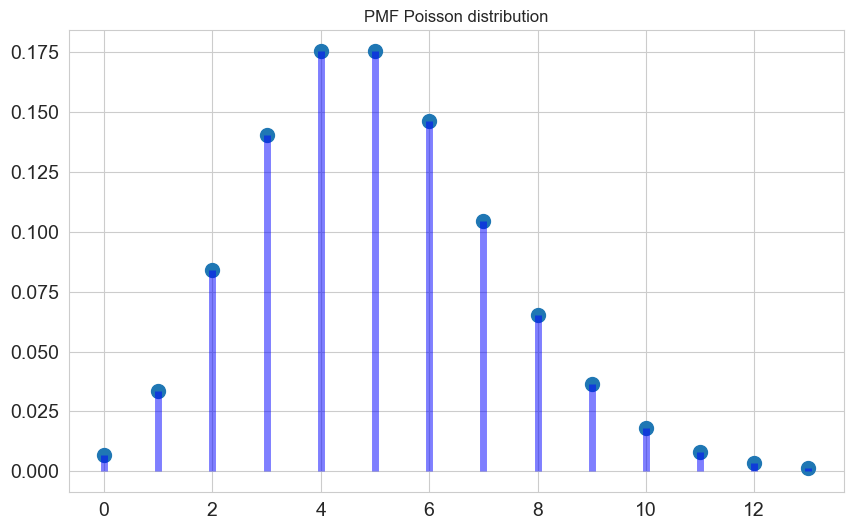

In [30]:
mu = 5
poissonDist = stats.poisson(mu=mu)

plot_discrete_dist(poissonDist, 'Poisson')

## Continuous Probability Distributions 📈

In [31]:
# define function that plots the pdf (and cdf) of continuous distributions
def plot_continuous_dist(distObject, name):
    positions = np.linspace(start=distObject.ppf(.001), stop=distObject.ppf(.999), num=500)

    plt.figure()
    plt.plot(positions, distObject.pdf(positions), label='PDF')
    # plt.plot(positions, distObject.cdf(positions), label='CDF')
    plt.title(f'PDF of {name} distribution')
    # plt.legend()
    plt.show()

### <font color=Navy Blue>Uniform</font>

- support: [$a$, $b$]
- parameters: lower bound $a$ and upper bound $b$
- example: 

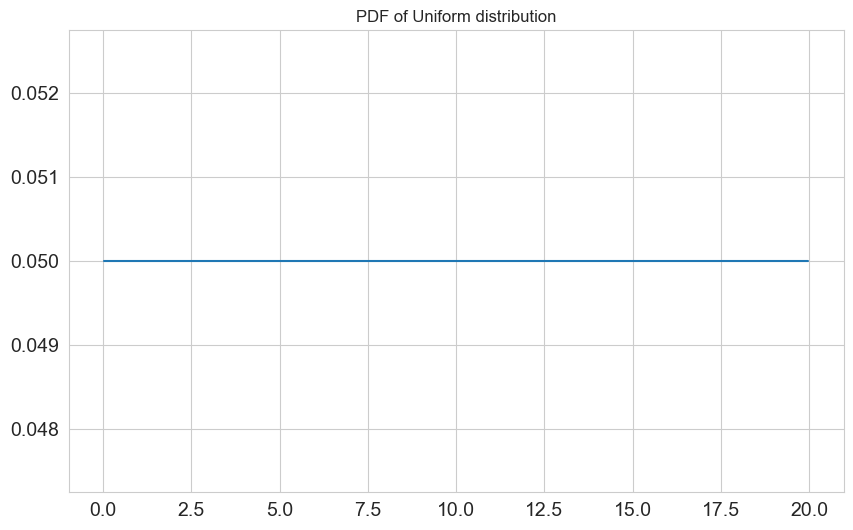

In [32]:
a = 0
b = 20
uniformDist = stats.uniform(a, b)

plot_continuous_dist(uniformDist, 'Uniform')

### <font color=Navy Blue>Beta</font>
$$f(x,a,b)=\frac{\Gamma(a+b)x^{a-1}(1-x)^{b-1}}{\Gamma(a)\Gamma(b)}$$

for $0\leq x\leq1,a>0,b>0$

- support: [0, 1]
- parameters: shape parameters $\alpha$ and $\beta$
- example:

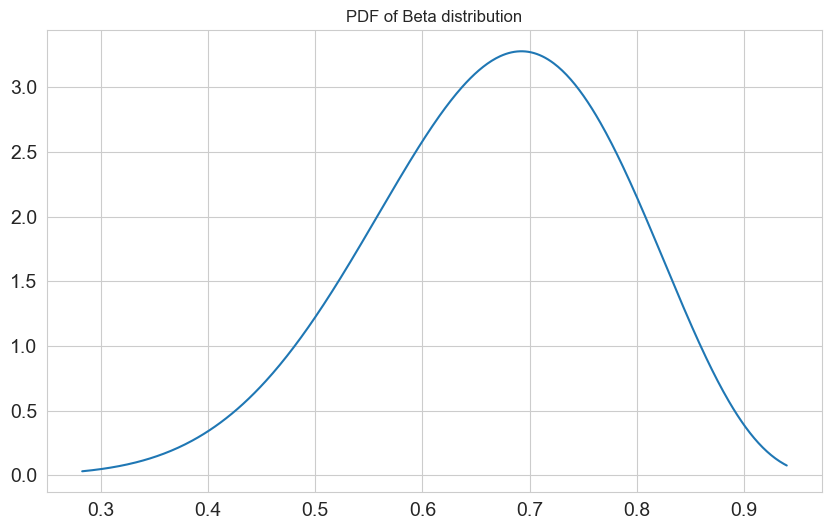

In [33]:
alpha = 10
beta = 5
betaDist = stats.beta(alpha, beta)

plot_continuous_dist(betaDist, 'Beta')

### <font color=Navy Blue>Normal</font>
$$f(x)=\frac{\exp(-x^2/2)}{\sqrt{2\pi}}$$
for $x\in\mathbb R$

- support: [$-\infty$, $\infty$]
- parameters: mean $\mu$ and standard deviation $\sigma$
- example:

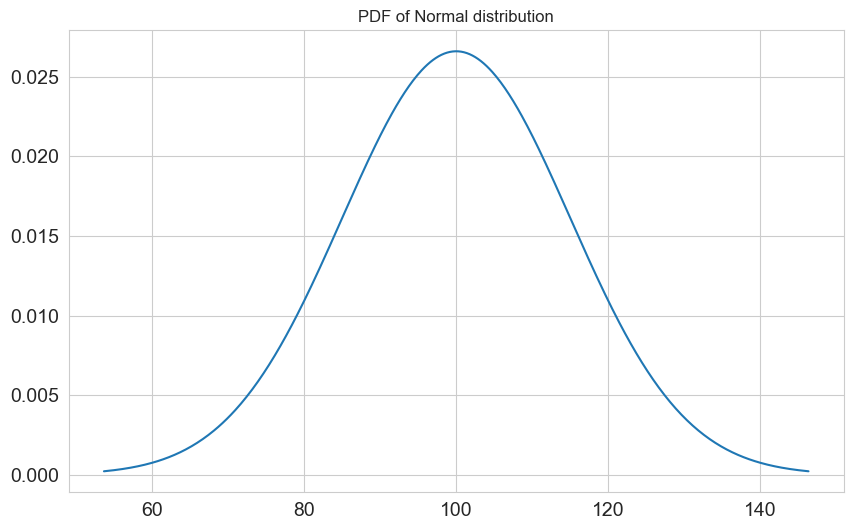

In [34]:
mu = 100
sigma = 15
normalDist = stats.norm(mu, sigma)

plot_continuous_dist(normalDist, 'Normal')

### <font color=Navy Blue>Student's <i>t</i></font>
$$f(x,\nu)=\frac{\Gamma((\nu+1)/2)}{\sqrt{\pi\nu}\Gamma(\nu/2)}(1+x^2/\nu)^{-(\nu+1)/2}$$

for $\nu>0$

If $\nu=1$ it is known as <b>Cauchy distribution</b>


- support: [$-\infty$, $\infty$]
- parameters: location $\mu$, scale $\sigma$ and $\nu$ that defines the probability mass in the tails
- example:

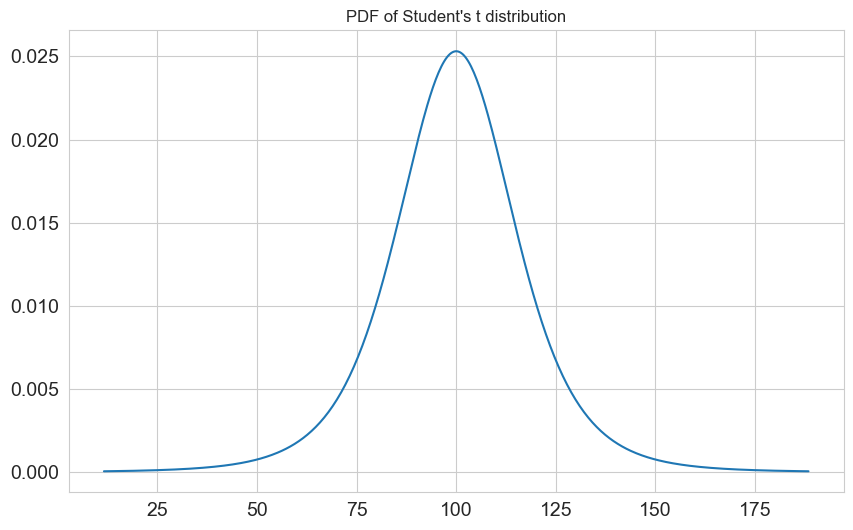

In [46]:
nu = 5
mu = 100
sigma = 15
studenttDist = stats.t(nu, loc=mu, scale=sigma)

plot_continuous_dist(studenttDist, "Student's t")

### <font color=Navy Blue>Cauchy</font>
$$f(x)=\frac{1}{\pi\gamma\left[1+\left(\frac{x-x_0}{\gamma}\right)^2\right]}$$

for $x\in\mathbb R, x_0\in\mathbb R, \gamma>0$ 


- support: [$-\infty$, $\infty$]
- parameters: location $x_0$ and scale $\gamma$
- example:

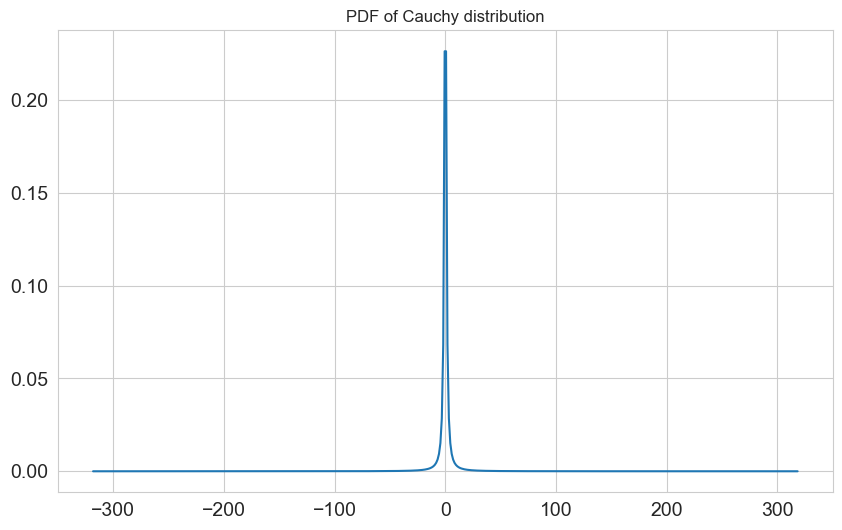

In [54]:
x0 = 0
gamma = 1
cauchyDist = stats.cauchy(loc=x0, scale=gamma)

plot_continuous_dist(cauchyDist, 'Cauchy')

### <font color=Navy Blue>Gamma</font>
$$f(x,\alpha,\beta)=\frac{\beta^\alpha x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$

for $x\geq0,\alpha>0,\beta>0$

- support: [0, $\infty$]
- parameters: shape parameter $\alpha$ and rate parameter $\beta$
- example:

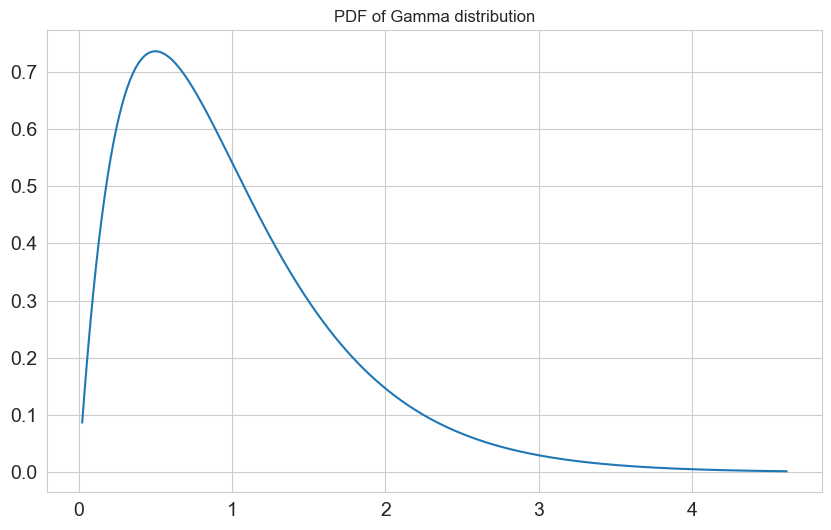

In [37]:
alpha = 2
beta = .5
gammaDist = stats.gamma(alpha, scale=beta)

plot_continuous_dist(gammaDist, 'Gamma')

### <font color=Navy Blue>Gumbel</font>
$$f(x)=\exp(x-e^x)$$

- interval: [$-\infty$, $\infty$]
- parameters: none $\to$ but there are two versions (left- and right-skewed: <code>gubel_l()</code> & <code>gumbel_r()</code>), and you can shift the distribution with the attribute <code>loc</code> and scale it with <code>scale</code>
- example:

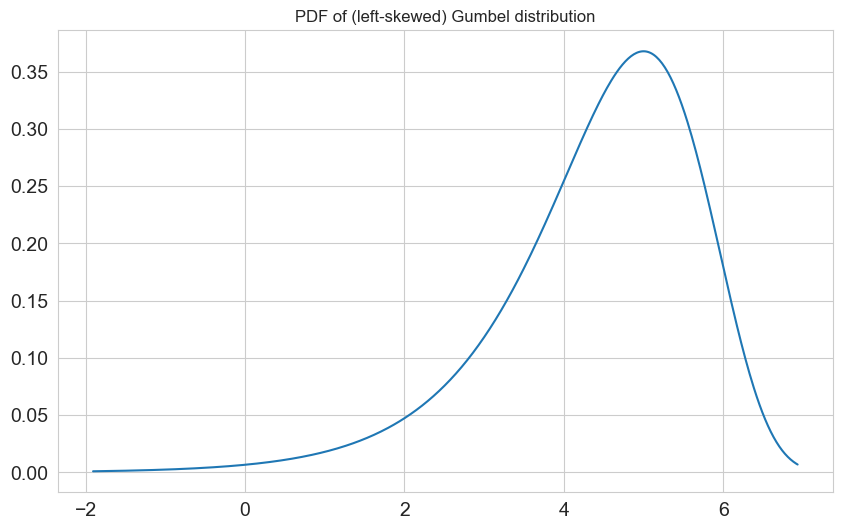

In [55]:
gumbelDist = stats.gumbel_l(loc=5)

plot_continuous_dist(gumbelDist, '(left-skewed) Gumbel')

## Multivariate
### <font color=Navy Blue>Multivariate Normal</font>
$$f(x)\frac{1}{\sqrt{(2\pi)^k\det\Sigma}}\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right)$$
- parameters: means $\mu$ and covariance matrix $\Sigma$
- example: 

In [39]:
means = np.array([1,-3])
covMat = np.array([[10,.9],[.9,10]])
multiNormDist = stats.multivariate_normal(mean=means, cov=covMat)

multiNormDist.rvs(10)

array([[ 1.60937158, -5.97219744],
       [ 1.34885215, -0.85045965],
       [ 1.33156044,  0.36385015],
       [ 4.0828499 , -2.7581009 ],
       [ 1.03327518, -4.18017318],
       [-2.51912854, -6.91093809],
       [ 2.38197272, -3.1225488 ],
       [-1.76875705,  2.37591567],
       [-0.48992438,  1.40296038],
       [ 0.8892052 , -2.21550551]])

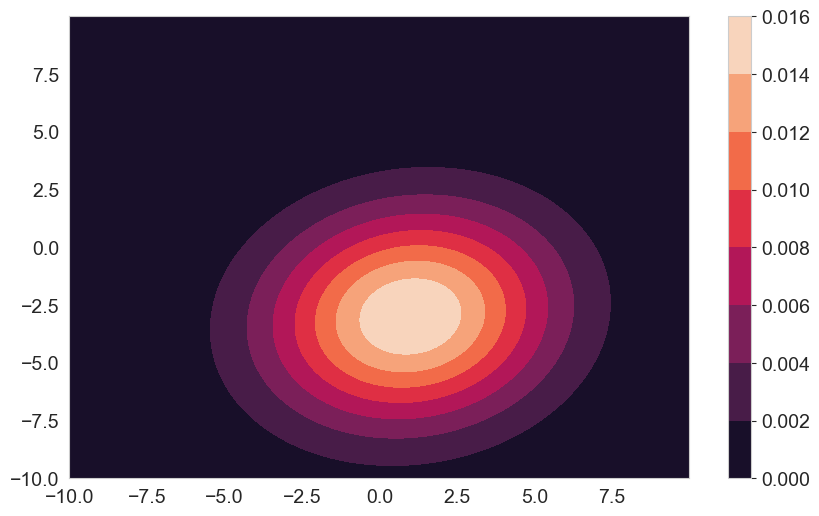

In [40]:
x, y = np.mgrid[-10:10:.01, -10:10:.01]
positions = np.dstack((x, y))

plt.contourf(x, y, multiNormDist.pdf(positions))
plt.colorbar()
plt.show()

### <font color=Navy Blue>Dirichlet</font>
$$f(x)=\frac{1}{B(\alpha)}\prod^K_{i=1}x_i^{\alpha_i-1}$$
where
$$B(\alpha)=\frac{\prod^K_{i=1}\Gamma(\alpha_i)}{\Gamma(\sum^K_{i=1}\alpha_i)}$$
- support: [0, 1]
- parameters: concentration parameters $\alpha$ (each entry must be positive)
- example:

In [41]:
alpha = np.array([.3,.5,.2])
dirirchletDist = stats.dirichlet(alpha=alpha)
dirirchletDist.rvs(10).round(2)

array([[0.05, 0.74, 0.21],
       [0.71, 0.29, 0.  ],
       [0.05, 0.8 , 0.16],
       [0.18, 0.82, 0.  ],
       [0.99, 0.  , 0.01],
       [0.18, 0.82, 0.  ],
       [0.38, 0.07, 0.55],
       [0.98, 0.02, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.01, 0.99, 0.  ]])

In [42]:
dirirchletDist.rvs(1000).mean(axis=0)

array([0.29942657, 0.50025036, 0.20032306])

For visualization see https://en.wikipedia.org/wiki/File:Dirichlet.pdf

### References

Murphy, K. P. (2022). <i>Probabilistic Machine Learning: An Introduction</i>. MIT Press.

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue May 27 2025

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

seaborn   : 0.13.0
pymc      : 5.9.0
numpy     : 1.25.2
arviz     : 0.16.1
scipy     : 1.11.3
matplotlib: 3.8.0

Watermark: 2.4.3

